# Calibrating Jensen Shannon

In [66]:
import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so


from distribution_diff import jensen_shannon_divergence, DistCalculator

## Generate the reference distribution

Gaussian, mean 0, standard deviation 1

In [8]:
rng = np.random.default_rng(seed=20230905)
reference_dist = rng.normal(loc=0, scale=1, size=1000)


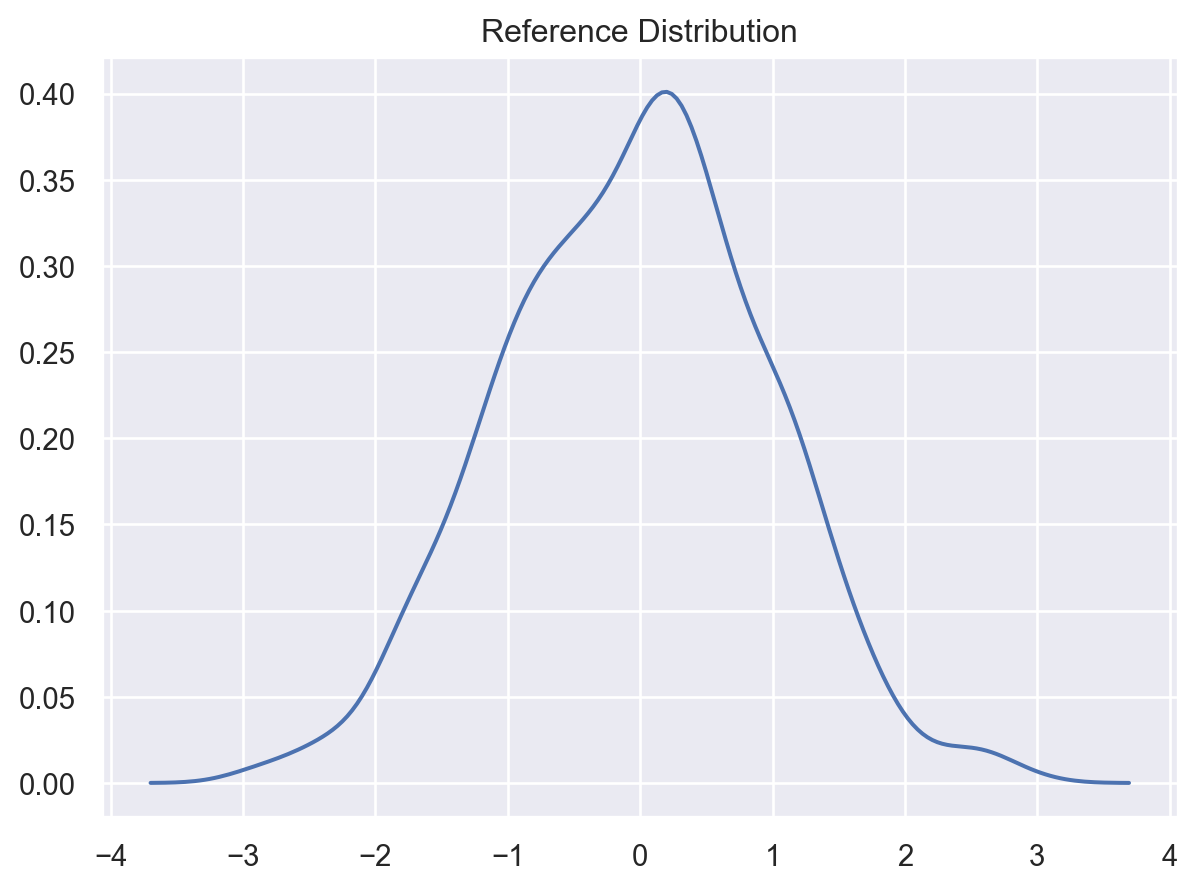

In [15]:
p = so.Plot(x=reference_dist).add(so.Line(), so.KDE())
p.label(title="Reference Distribution")

In [16]:
# create a PSI calculator with this reference distribution
psiCalc = DistCalculator(reference_dist)

## Bootstrap sampling

Both Jensen-Shannon and PSI will be measured with decile binning.

In [20]:
niters = 1000
jsvec = []
psivec = []

for i in range(niters):
    bsample = rng.choice(reference_dist, size=len(reference_dist), replace=True)
    jsvec.append(jensen_shannon_divergence(bsample, reference_dist))
    psivec.append(psiCalc.PSI(bsample))

flist = [
    pd.DataFrame({
        'div': jsvec,
        'type': 'Jensen-Shannon'
    }),
    pd.DataFrame({
        'div': psivec,
        'type': 'PSI'
    }),
]

pframe = pd.concat(flist)
pframe


,div,type
0,0.001495,Jensen-Shannon
1,0.002204,Jensen-Shannon
2,0.002047,Jensen-Shannon
3,0.001911,Jensen-Shannon
4,0.002893,Jensen-Shannon
...,...,...
995,0.007077,PSI
996,0.010535,PSI
997,0.004947,PSI
998,0.006742,PSI


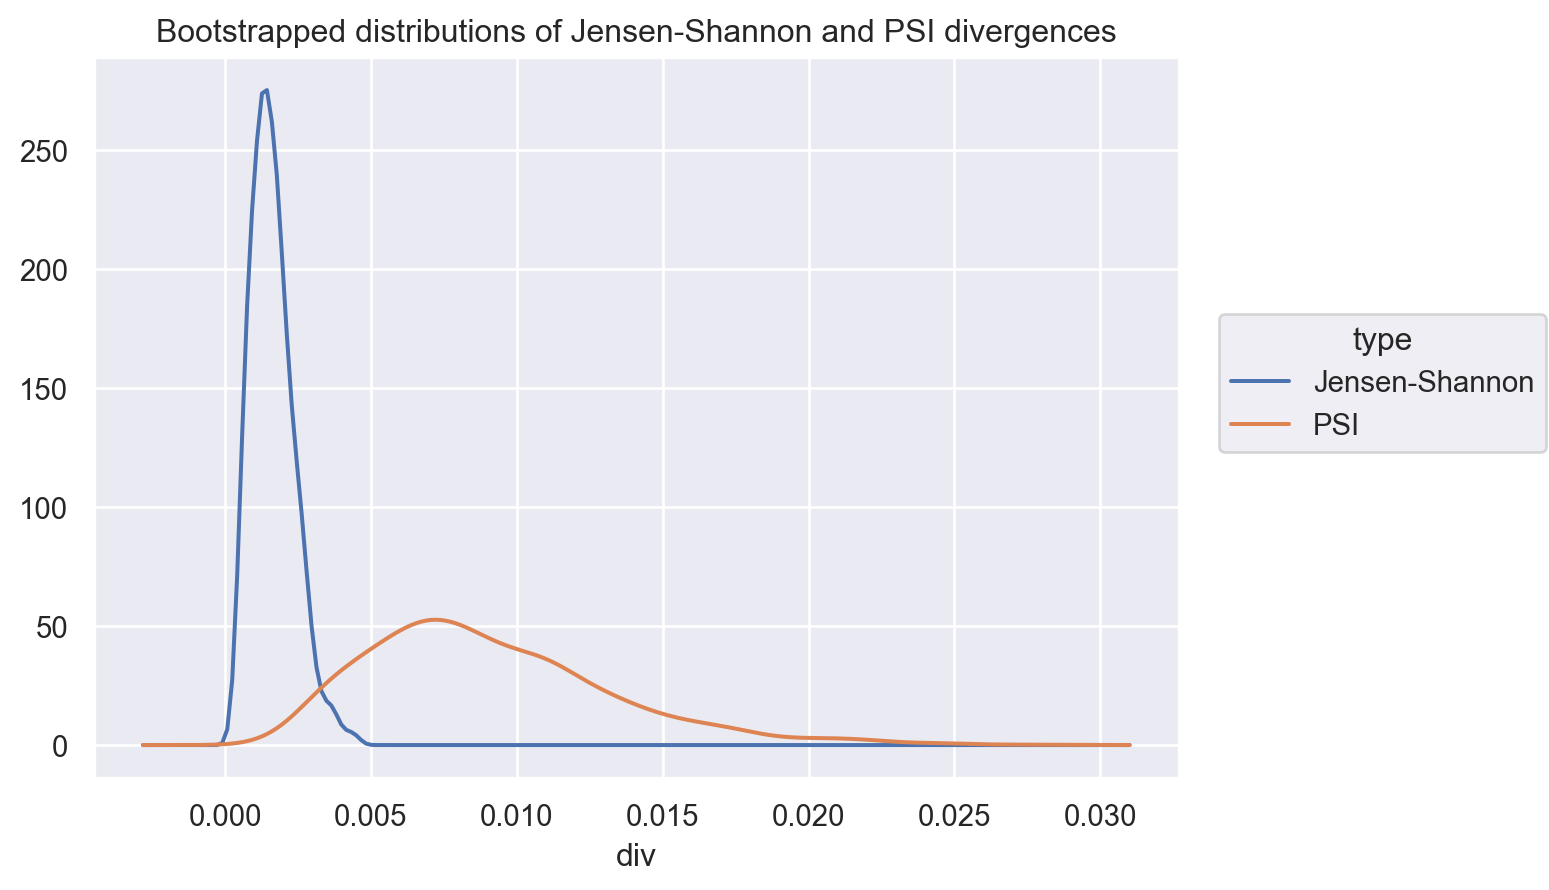

In [24]:
p = so.Plot(pframe, "div", color="type").add(so.Line(), so.KDE())
p.label(title='Bootstrapped distributions of Jensen-Shannon and PSI divergences')

## Distribution drift

We'll be measuring increasing variance (but we'll hold the mean the same)

In [43]:
def generate_comparison(newscale, niter=10):
    jsvec = []
    psivec = []
    for i in range(niter):
        bsample = rng.normal(loc=0, scale=newscale, size=1000)
        jsvec.append(jensen_shannon_divergence(bsample, reference_dist))
        psivec.append(psiCalc.PSI(bsample))

    ns = f'{newscale:.2f}'
    flist = [
        pd.DataFrame({
            'scale': newscale,
            'div': jsvec,
            'type': 'Jensen-Shannon'
        }),
        pd.DataFrame({
            'scale': newscale,
            'div': psivec,
            'type': 'PSI'
        }),
    ]

    return(pd.concat(flist))


In [53]:
def minmax(v):
    return np.array([v.min(), v.max()])



array([1, 3])

In [52]:
np.array([1, 2, 3])

array([1, 2, 3])

In [46]:
newscales = np.linspace(1, 2, num=20, endpoint=True)
flist = [generate_comparison(ns) for ns in newscales]
pframe = pd.concat(flist)
pframe



,scale,div,type
0,1.0,0.006291,Jensen-Shannon
1,1.0,0.005732,Jensen-Shannon
2,1.0,0.006324,Jensen-Shannon
3,1.0,0.007119,Jensen-Shannon
4,1.0,0.005050,Jensen-Shannon
...,...,...,...
5,2.0,0.495927,PSI
6,2.0,0.545820,PSI
7,2.0,0.475514,PSI
8,2.0,0.632139,PSI


In [74]:

p = (so.Plot(pframe, x="scale", y="div", color="type")
       .add(so.Dots(), so.Agg("median"))
       .add(so.Range(), so.Est(errorbar=minmax))
       .label(title='Divergence values as scale increases')
)


# p.show()


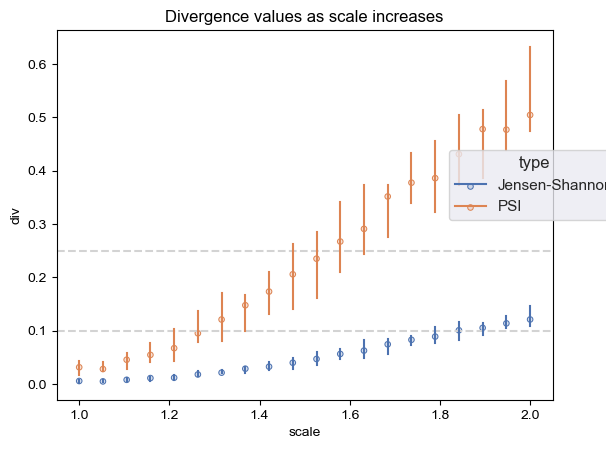

In [76]:
fig, ax = plt.subplots()
plt.axhline(y=0.1, color='lightgray', linestyle='--')
plt.axhline(y=0.25, color='lightgray', linestyle='--')
p.on(ax).show()

In [78]:
pframe

,scale,div,type
0,1.0,0.006291,Jensen-Shannon
1,1.0,0.005732,Jensen-Shannon
2,1.0,0.006324,Jensen-Shannon
3,1.0,0.007119,Jensen-Shannon
4,1.0,0.005050,Jensen-Shannon
...,...,...,...
5,2.0,0.495927,PSI
6,2.0,0.545820,PSI
7,2.0,0.475514,PSI
8,2.0,0.632139,PSI


In [87]:
sframe = (
    pframe
        .groupby(["scale", "type"])
        .mean()
        .reset_index(drop=False, inplace=False)
)
s_j = (
    sframe
        .loc[sframe["type"] == "Jensen-Shannon", :]
        .reset_index(drop=True, inplace=False)
        .rename(columns={"div": "Jensen-Shannon divergence"})
)
del s_j["type"]
s_p = (
    sframe
        .loc[sframe["type"] == "PSI", :]
        .reset_index(drop=True, inplace=False)
        .rename(columns={"div": "PSI divergence"})
)
del s_p["type"]
splot = (
    s_j
        .merge(
            s_p,
            on=["scale"]
        )
)



splot['PSI heuristic'] = np.where(splot['PSI divergence'] < 0.1, 'not very different',
                                   np.where(splot['PSI divergence'] > 0.25, 'very different', 'somewhat different'))
splot

,scale,Jensen-Shannon divergence,PSI divergence,PSI heuristic
0,1.000000,0.005172,0.032086,not very different
1,1.052632,0.005299,0.030807,not very different
2,1.105263,0.008620,0.045650,not very different
3,1.157895,0.010947,0.056278,not very different
4,1.210526,0.012654,0.067650,not very different
5,1.263158,0.019304,0.100244,somewhat different
6,1.315789,0.022859,0.127586,somewhat different
7,1.368421,0.028181,0.142169,somewhat different
8,1.421053,0.033231,0.170605,somewhat different
9,1.473684,0.039300,0.199068,somewhat different


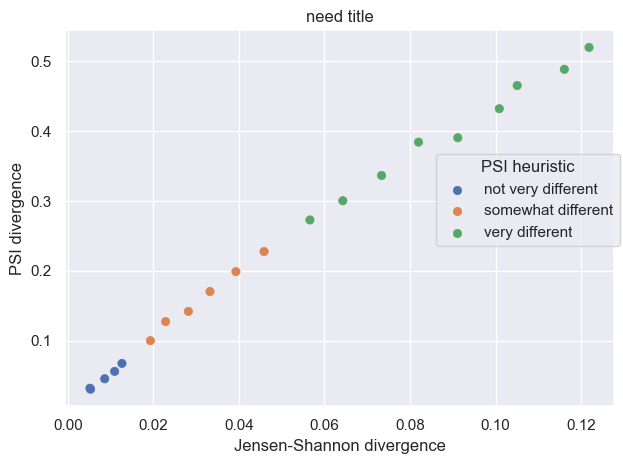

In [88]:

p = (so.Plot(splot, x="Jensen-Shannon divergence", y="PSI divergence", color="PSI heuristic")
       .add(so.Dot())
       .label(title='need title')
)

p.show()


## Fit the relationship

Keep in mind that the aggregation used above was median, not mean.

And yes, I know I should probably do this with `statsmodels`, but sklearn is easier to use, and I'm not concerned with significances (given that the relationship is quite clear).

In [89]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(splot.loc[:, ['PSI divergence']], splot['Jensen-Shannon divergence'])

LinearRegression()

In [91]:
[lm.intercept_, lm.coef_]

[-0.004919439988152419, array([0.23813964])]

So one can say (at least for this problem, in this range) that the Jensen Shannon divergence is approximately 0.238 PSI. The relationship likely will vary with the distribution (see `test_cnc_anomaly.ipynb` for another example.)

In [96]:
lower_JS_threshold = lm.intercept_ + 0.1 * lm.coef_
upper_JS_threshold = lm.intercept_ + 0.25 * lm.coef_


print(f'''
Heuristic thresholds for Jensen-Shannon divergence:
* over {lower_JS_threshold[0]}: "somewhat different"
* over {upper_JS_threshold[0]}: "very different"
''')


Heuristic thresholds for Jensen-Shannon divergence:
* over 0.018894523688500194: "somewhat different"
* over 0.05461546920347911: "very different"

